In [2]:
from __future__ import annotations
import os
import numpy as np
import torch
import time
from pytomography.io.SPECT import dicom
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform, CutOffTransform, KEMTransform
from pytomography.algorithms import BSREM, KEM, OSEM
from pytomography.projectors import SPECTSystemMatrix
from pytomography.priors import TopNAnatomyNeighbourWeight, RelativeDifferencePrior
from pytomography.callbacks import Callback
import numpy.linalg as npl
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.colors import LinearSegmentedColormap
from torchmetrics.image import StructuralSimilarityIndexMeasure
import pydicom

Change this to where you saved the data

In [3]:
datapath = '/disk1/pytomography_paper_data/'

Change this to where you would like to save output

In [4]:
savepath = '/disk1/pytomography_paper_results/data/deepblue_recons'

Open data

In [5]:
path = os.path.join(datapath, 'dicom/deepblue_proj')
files_NM = [os.path.join(path, 'scan1/C2S1D0-SPECT-Projections/2.16.840.1.114362.1.11979141.22403444876.563074954.775.11.dcm'),
            os.path.join(path, 'scan2/C2S2D1-SPECT-Projections/2.16.840.1.114362.1.11979141.22403444876.563074962.704.2214.dcm'),
            os.path.join(path, 'scan3/C2S3D4-SPECT-Projections/2.16.840.1.114362.1.11979141.22403444876.563074961.612.1997.dcm'),
            os.path.join(path, 'scan4/C2S4D5-SPECT-Projections/2.16.840.1.114362.1.11979141.22403444876.563074960.959.1972.dcm')]
path = os.path.join(datapath, 'dicom/deepblue_recon')
paths_CT = [os.path.join(path, 'scan1/ct'),
            os.path.join(path, 'scan2/ct'),
            os.path.join(path, 'scan3/ct'),
            os.path.join(path, 'scan4/ct')]
filess_CT = [[os.path.join(path_CT, file) for file in os.listdir(path_CT)] for path_CT in paths_CT]

Go to "Plotting" if reconstructions already done

# Reconstructing

In [5]:
object_meta, proj_meta = dicom.get_metadata(files_NM[0])
photopeak = dicom.get_projections(files_NM[0], index_peak=0)
scatter = dicom.get_scatter_from_TEW(files_NM[0], index_peak=0, index_lower=1, index_upper=2)

In [6]:
attenuation_map_from_CT_slices = dicom.get_attenuation_map_from_CT_slices(filess_CT[0], files_NM[0], index_peak=0, keep_as_HU=True, mode='nearest')

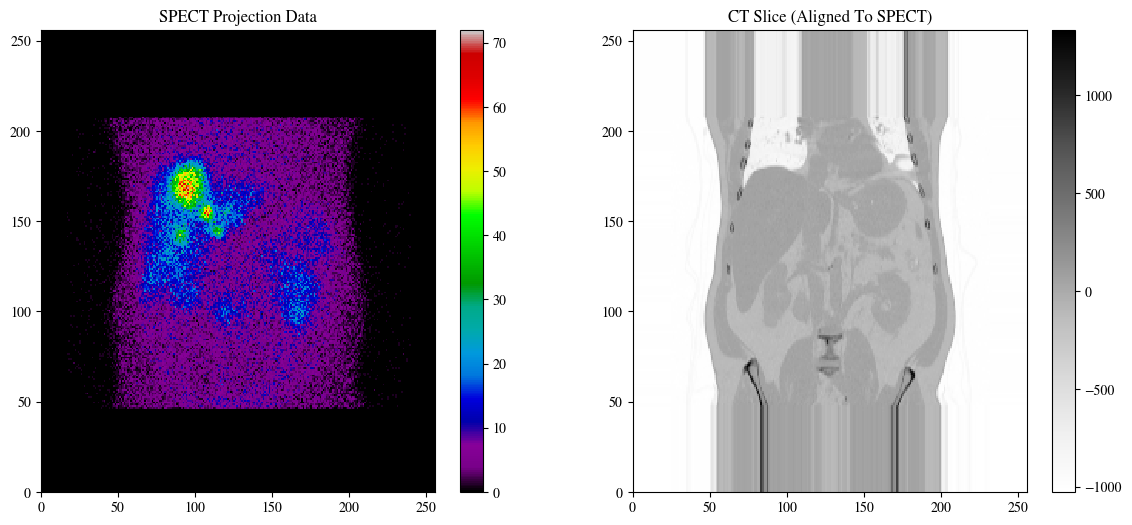

In [7]:
plt.subplots(1,2,figsize=(14,6))
plt.subplot(121)
plt.title('SPECT Projection Data')
plt.pcolormesh(photopeak.cpu()[0,0].T, cmap='nipy_spectral')
plt.colorbar()
plt.subplot(122)
plt.title('CT Slice (Aligned To SPECT)')
plt.pcolormesh(attenuation_map_from_CT_slices[0][:,128].cpu().T, cmap='Greys')
plt.colorbar()

Kidney mask and callback
* Kidney segmentations obtained by using wholebodyCT segmentation model from MONAI

In [8]:
def load_mask(i):
    mask = np.load(os.path.join(datapath, 'dicom/deepblue_masks/' f'deepbluepatient4scan{i+1}.npy'))
    # Left kidney only
    mask = (mask==3).astype(np.float32)
    M_CT = dicom._get_affine_CT(filess_CT[i])
    M_NM = dicom._get_affine_spect_projections(files_NM[i])
    M = npl.inv(M_CT) @ M_NM
    ds_NM = pydicom.read_file(files_NM[i])
    mask = dicom.affine_transform(mask, M, output_shape=(ds_NM.Rows, ds_NM.Rows, ds_NM.Columns), mode='constant', cval=0, order=1)
    mask = mask>=1
    return mask

class SaveData(Callback):
    def __init__(self, kidney_mask):
        self.kidney_mask = kidney_mask
        self.activities = []
        self.n_subset_save = 7
        
    def run(self, object, n_iter):
        self.activities.append(object[0].cpu().numpy()[self.kidney_mask].mean())

Reconstruction

In [9]:
def reconstruct_singlebed(i, algorithm, algorithm_kwargs, callback=None, n_iters=5):
    file_NM = files_NM[i]
    files_CT = filess_CT[i]
    object_meta, proj_meta = dicom.get_metadata(file_NM)
    photopeak = dicom.get_projections(file_NM, index_peak=0)
    scatter = dicom.get_scatter_from_TEW(file_NM, index_peak=0, index_lower=1, index_upper=2)
    attenuation_map = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=0)
    if algorithm==BSREM:
        prior_weight = TopNAnatomyNeighbourWeight(attenuation_map, 8)
        prior = RelativeDifferencePrior(beta=0.3, gamma=2, weight=prior_weight)
        algorithm_kwargs['prior'] = prior
        
    if algorithm==KEM:
        algorithm_kwargs['kem_transform'] = KEMTransform(
        support_objects=[attenuation_map],
        support_kernels_params=[[0.005]],
        distance_kernel_params=[0.5],
        kernel_on_gpu=False,
        top_N = 40)
        
    psf_meta = dicom.get_psfmeta_from_scanner_params('SY-ME', energy_keV=208, min_sigmas=3)
    att_transform = SPECTAttenuationTransform(filepath=files_CT, mode='nearest')
    psf_transform = SPECTPSFTransform(psf_meta)
    cutoff_transform = CutOffTransform(file_NM=file_NM)
    # Create system matrix
    system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [cutoff_transform],
        object_meta = object_meta,
        proj_meta = proj_meta,
        n_parallel=5)
    # Initialize reconstruction algorithm
    reconstruction_algorithm = algorithm(
        projections = photopeak,
        system_matrix = system_matrix,
        scatter=scatter,
        **algorithm_kwargs)
    # Reconstruct object
    t_start = time.time()
    reconstructed_object = reconstruction_algorithm(n_iters=n_iters, n_subsets=8, callback=callback)
    reconstructed_object = reconstructed_object[0].cpu().numpy()
    #reconstructed_object = cutoff_transform.forward(reconstructed_object)[0].cpu().numpy()
    t_elapsed = time.time() - t_start
    np.save(file=os.path.join(savepath, f'patient4_time{i+1}_{algorithm.__name__}_{n_iters}it_object'), arr=reconstructed_object)
    if callback is not None:
        np.savez(os.path.join(savepath, f'patient4_time{i+1}_{algorithm.__name__}_{n_iters}it'), t_elapsed=t_elapsed, activities=callback.activities)

Reconstruction using prior

In [14]:
algorithms = [OSEM, BSREM, KEM]
algorithm_kwargss = [{}, {'relaxation_function': lambda n: 1}, {}]
for algorithm, algorithm_kwargs in zip(algorithms, algorithm_kwargss):
    callback = SaveData(load_mask(0))
    reconstruct_singlebed(0, n_iters=50, algorithm = algorithm, algorithm_kwargs=algorithm_kwargs, callback=callback)

# Plotting

In [6]:
algorithms = [OSEM, BSREM, KEM]
recons = []
recons_info = []
for algorithm in algorithms:
    recons.append(np.load(os.path.join(savepath, f'patient4_time1_{algorithm.__name__}_50it_object.npy')))    
    recons_info.append(np.load(os.path.join(savepath, f'patient4_time1_{algorithm.__name__}_50it.npz')))

In [7]:
recons_info[0]['activities'][-1]

2.1947114

In [8]:
recons_info[1]['activities'][-1]

2.2566488

In [9]:
recons_info[2]['activities'][-1]

2.2041864

In [10]:
recons_info[2]['t_elapsed'] / 50

36.504776821136474

In [11]:
CT = dicom.get_attenuation_map_from_CT_slices(filess_CT[0], files_NM[0])

In [12]:
def cmap_f(x,a):
    return (1-np.exp(-x/a))/(1+np.exp(-x/a))

In [13]:
colors = np.loadtxt('pet_colors.txt').reshape(-1,3)/255.0
existing_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
# Create a new colormap based on the existing one
colors = existing_cmap(np.linspace(0, 1, 256))
x = np.linspace(0,1,256)
colors[:, -1] = 0.8*cmap_f(x, 5e-2)
new_cmap = mcolors.LinearSegmentedColormap.from_list('NewColormap', colors)

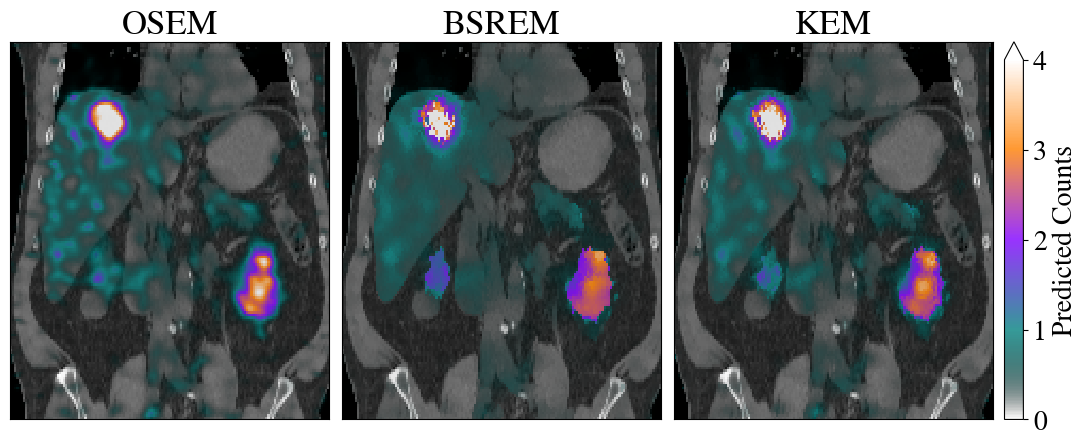

In [14]:
slcs = np.array([64,64,64,64])*2 -4
body = 1
fig, ax = plt.subplots(1,3,figsize=(12,4.4))
for i in range(3):
    ax[i].pcolormesh(CT.cpu().numpy()[0,:,slcs[i]].T, cmap='Greys_r', vmin=0.106, vmax=0.2)
    im = ax[i].pcolormesh(recons[i][:,slcs[i]].T, cmap=new_cmap, vmax=4)
    ax[i].set_xlim(50,200)
    ax[i].set_ylim(50,200)
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax[i].set_title(f'{algorithms[i].__name__}', fontsize=25)

fig.tight_layout()
cbar = fig.colorbar(im, ax=ax, location='right', extend='max', pad=0.01)
cbar.set_label('Predicted Counts', size=20)
cbar.ax.tick_params(labelsize=20) 
#fig.tight_layout()
plt.savefig('images/figure6_part1.jpg', dpi=300, bbox_inches='tight')

Load masks to plot dose volume histograms
* Masks obtained from MONAI's wholebody CT model

In [15]:
object_meta, proj_meta = dicom.get_metadata(files_NM[0])

In [19]:
def load_mask(i, organ_idx):
    mask_all = np.load(os.path.join(datapath, 'dicom/deepblue_masks/' f'deepbluepatient4scan{i+1}.npy'))
    if type(organ_idx) is int:
        mask = (mask_all==organ_idx).astype(np.float32)
    else:
        mask = np.zeros(mask_all.shape)
        for organ_i in organ_idx:
            mask+=(mask_all==organ_i)
        mask = mask.astype(np.float32)
    ds_NM = pydicom.read_file(files_NM[i])
    M_CT = dicom._get_affine_CT(filess_CT[i])
    M_NM = dicom._get_affine_spect_projections(files_NM[i])
    M = npl.inv(M_CT) @ M_NM
    mask = dicom.affine_transform(mask, M, output_shape=(ds_NM.Rows, ds_NM.Rows, ds_NM.Columns), mode='constant', cval=0, order=1)
    mask = mask>=0.5
    return mask

In [20]:
m1 = load_mask(0, [2,3])
m2 = load_mask(0, 5)
mtot = m1+m2

In [26]:
print(f'OSEM {recons[0][m1].mean()}')
print(f'BSREM {recons[1][m1].mean()}')
print(f'KEM {recons[2][m1].mean()}')

OSEM 1.9833096265792847
BSREM 2.0703678131103516
KEM 2.0204689502716064


In [27]:
print(f'OSEM {recons[0][m2].mean()}')
print(f'BSREM {recons[1][m2].mean()}')
print(f'KEM {recons[2][m2].mean()}')

OSEM 0.9266637563705444
BSREM 0.9324346780776978
KEM 0.9297828078269958


Look at the masks:

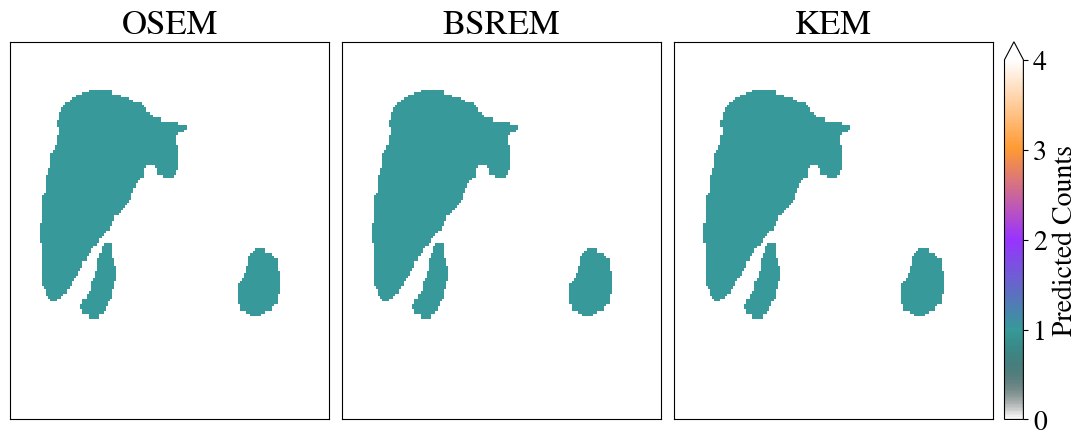

In [22]:
slcs = np.array([64,64,64,64])*2 -4
body = 1
fig, ax = plt.subplots(1,3,figsize=(12,4.4))
for i in range(3):
    im = ax[i].pcolormesh(mtot[:,slcs[i]].T, cmap=new_cmap, vmax=4)
    ax[i].set_xlim(50,200)
    ax[i].set_ylim(50,200)
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax[i].set_title(f'{algorithms[i].__name__}', fontsize=25)

fig.tight_layout()
cbar = fig.colorbar(im, ax=ax, location='right', extend='max', pad=0.01)
cbar.set_label('Predicted Counts', size=20)
cbar.ax.tick_params(labelsize=20) 
#fig.tight_layout()